In [3]:
# Load basic dependencies:
import warnings
warnings.filterwarnings('ignore')
import time
import csv

%matplotlib inline
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd

# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

# Load Keras dependencies:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.preprocessing.preprocessing import Preprocessor
from art.defences.preprocessor import SpatialSmoothing
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import to_categorical


import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

2023-04-07 23:25:21.906876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 23:25:22.923661: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/machinelearner/anaconda3/envs/tf/lib/
2023-04-07 23:25:22.923736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/machinelearner/anaconda3/envs/tf/lib/
2023-04-07 23:25:22.923742: W tensorflow

In [4]:
#Loading the demo images
images_list = list()
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    images_list.append(im)
    if 'unicycle.jpg' in image_path:
        # get unicycle index
        unicycle_idx = i
images = np.array(images_list)

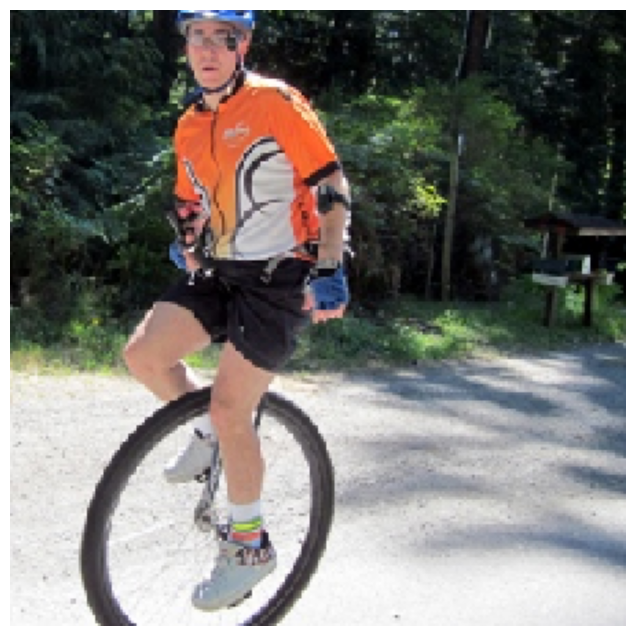

In [21]:
#Selecting the Unicycle image as input
idx = unicycle_idx
x_art = np.expand_dims(images[idx], axis=0) 
plt.figure(figsize=(8,8)); plt.imshow(images[idx] / 255); plt.axis('off'); plt.show()

In [6]:
print('Number of images:', images.shape[0])
print('Dimension of images:', images.shape[1], 'x', images.shape[2], 'pixels')
print('Number of color channels:', images.shape[3], '(RGB)')

Number of images: 16
Dimension of images: 224 x 224 pixels
Number of color channels: 3 (RGB)


In [12]:
for i in range(1000):
    print('label', i, '-', label_to_name(i))

label 0 - tench, Tinca tinca
label 1 - goldfish, Carassius auratus
label 2 - great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
label 3 - tiger shark, Galeocerdo cuvieri
label 4 - hammerhead, hammerhead shark
label 5 - electric ray, crampfish, numbfish, torpedo
label 6 - stingray
label 7 - cock
label 8 - hen
label 9 - ostrich, Struthio camelus
label 10 - brambling, Fringilla montifringilla
label 11 - goldfinch, Carduelis carduelis
label 12 - house finch, linnet, Carpodacus mexicanus
label 13 - junco, snowbird
label 14 - indigo bunting, indigo finch, indigo bird, Passerina cyanea
label 15 - robin, American robin, Turdus migratorius
label 16 - bulbul
label 17 - jay
label 18 - magpie
label 19 - chickadee
label 20 - water ouzel, dipper
label 21 - kite
label 22 - bald eagle, American eagle, Haliaeetus leucocephalus
label 23 - vulture
label 24 - great grey owl, great gray owl, Strix nebulosa
label 25 - European fire salamander, Salamandra salamandra
label 26 

In [8]:
target_label = 94

In [9]:
#Using the ResNet50 model set with imagenet weights as a base for our classifier
model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


2023-04-07 23:26:03.379356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-07 23:26:03.398708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-07 23:26:03.398762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-07 23:26:05.881159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [12]:
class ResNet50Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        return preprocess_input(x.copy()), y

    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1] 

In [13]:
preprocessor = ResNet50Preprocessor()

In [14]:
#Creating an instance of a normal classifier to act as control
normalclassifier=KerasClassifier(model,clip_values=(0, 255), preprocessing=preprocessor)

In [17]:
class BetterClassifierWithoutRandom(KerasClassifier):
    
    def predict(
        self, x: np.ndarray, batch_size: int = 128, training_mode: bool = False, **kwargs
    ) -> np.ndarray:
        """
        Perform prediction for a batch of inputs.

        :param x: Input samples.
        :param batch_size: Size of batches.
        :param training_mode: `True` for model set to training mode and `'False` for model set to evaluation mode.
        :return: Array of predictions of shape `(nb_inputs, nb_classes)`.
        """
        # Apply preprocessing
        x_preprocessed, _ = self._apply_preprocessing(x, y=None, fit=False)

        # Create containers for our predictions and spatial smoothening window sizes
        prediction_labels=[]
        prediction_scores=[]
        label_counts={}
        smoothening_values=[1,2,3,3,4,4,5,5,6,7]
        
        #Predict with each window size, and store the labels and prediction scores in their containers
        for i in smoothening_values:
            ss=SpatialSmoothing(window_size=i)
            x_def,_=ss(x_preprocessed)
            pred = self._model.predict(x_def,batch_size=batch_size)
            label = label_to_name(np.argmax(pred, axis=1)[0])
            prediction_scores.append(pred)
            prediction_labels.append(label)
        
        #finding out which label is most frequently identified, and taking a weighted mean of that label's scores
        for label in prediction_labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
                
        most_frequent_label = max(label_counts, key=label_counts.get)
        most_frequent_indexes = [i for i, p in enumerate(prediction_labels) if p == most_frequent_label]
        most_frequent_pred_scores = [prediction_scores[i] for i in most_frequent_indexes]

        weights = 1/np.array([smoothening_values[i] for i in most_frequent_indexes])
        predictions = np.average(most_frequent_pred_scores,axis=0,weights=weights)
        
        # Apply postprocessing
        predictions = self._apply_postprocessing(preds=predictions, fit=False)

        return predictions

In [18]:
#Creating an instance of our classifier without randomness to act as control for smoothing values 
betterclassifierwithoutrandom = BetterClassifierWithoutRandom(model,clip_values=(0, 255), preprocessing=preprocessor)

In [19]:
class BetterClassifier(KerasClassifier):
        
    def predict(
        self, x: np.ndarray, batch_size: int = 128, training_mode: bool = False, **kwargs
    ) -> np.ndarray:
        """
        Perform prediction for a batch of inputs.

        :param x: Input samples.
        :param batch_size: Size of batches.
        :param training_mode: `True` for model set to training mode and `'False` for model set to evaluation mode.
        :return: Array of predictions of shape `(nb_inputs, nb_classes)`.
        """
        # Apply preprocessing
        x_preprocessed, _ = self._apply_preprocessing(x, y=None, fit=False)

        # Create containers for our predictions and spatial smoothening window sizes
        prediction_labels=[]
        prediction_scores=[]
        label_counts={}
        smoothening_values=[np.random.randint(1,7) for i in range(10)]
        
        #Predict with each window size, and store the labels and prediction scores in their containers
        for i in smoothening_values:
            ss=SpatialSmoothing(window_size=i)
            x_def,_=ss(x_preprocessed)
            pred = self._model.predict(x_def,batch_size=batch_size)
            label = label_to_name(np.argmax(pred, axis=1)[0])
            prediction_scores.append(pred)
            prediction_labels.append(label)
        
        #finding out which label is most frequently identified, and taking a weighted mean of that label's scores
        for label in prediction_labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
                
        most_frequent_label = max(label_counts, key=label_counts.get)
        most_frequent_indexes = [i for i, p in enumerate(prediction_labels) if p == most_frequent_label]
        most_frequent_pred_scores = [prediction_scores[i] for i in most_frequent_indexes]

        weights = 1/np.array([smoothening_values[i] for i in most_frequent_indexes])
        predictions = np.average(most_frequent_pred_scores,axis=0,weights=weights)
        
        # Apply postprocessing
        predictions = self._apply_postprocessing(preds=predictions, fit=False)
        return predictions

In [20]:
#Creating an instance of our classifier
betterclassifier = BetterClassifier(model,clip_values=(0, 255), preprocessing=preprocessor)

In [ ]:
#Creating attacks for the three classifier instances

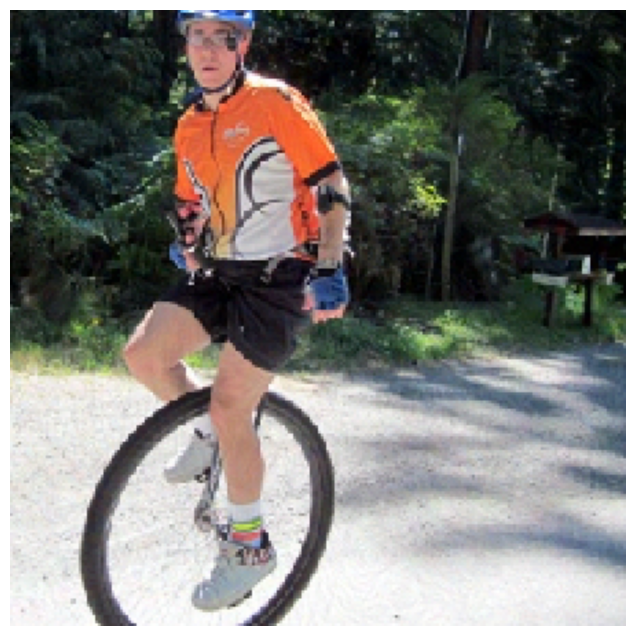

Prediction: hummingbird - confidence 0.97


In [28]:
#Attacking the normal classifier with a targeted attack
adv_def = ProjectedGradientDescent(normalclassifier, targeted=True, max_iter=10, eps_step=1, eps=5,verbose=False)

# Generate the adversarial sample:
x_art_adv_def = adv_def.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = normalclassifier.predict(x_art_adv_def)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

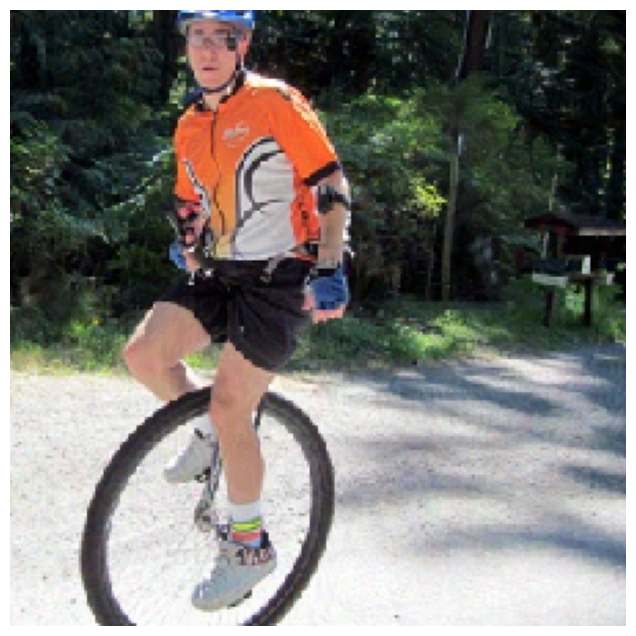

Prediction: unicycle, monocycle - confidence 0.93


In [31]:
#Attacking our classifier without randomness with a targeted attack
adv_def = ProjectedGradientDescent(betterclassifierwithoutrandom, targeted=True, max_iter=40, eps_step=1, eps=5,verbose=False)

# Generate the adversarial sample:
x_art_adv_def = adv_def.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = betterclassifierwithoutrandom.predict(x_art_adv_def)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

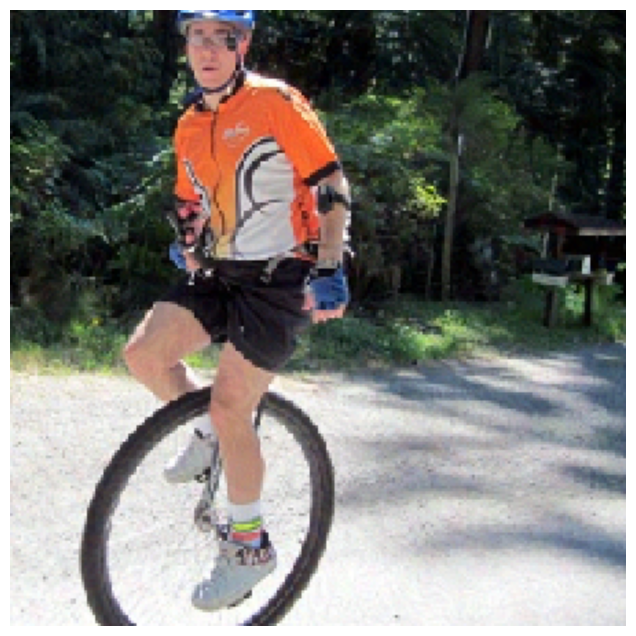

Prediction: unicycle, monocycle - confidence 0.97


In [27]:
#Attacking our classifier with a targeted attack
adv_def = ProjectedGradientDescent(betterclassifier, targeted=True, max_iter=40, eps_step=1, eps=5,verbose=False)

# Generate the adversarial sample:
x_art_adv_def = adv_def.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = betterclassifier.predict(x_art_adv_def)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

## Conclusions

We have walked through an end-to-end example of attacking a normal classifier with a PGD attack, and then shown how our suggested defence can defeat such attacks. 